# Assignment
Build the AlexNet architecture and train it on the CIFAR10 dataset.

You may resize some of the kernel sizes (mainly the first one) and the number of kernels because CIFAR100 is a smaller dataset than ImageNet, as well as lower-resolution (32x32 vs 224x224).

You may resize the number of kernels used per layer if it speeds up training and/or preserves accuracy. The exact AlexNet architecture and number of units will not work.

Report training, validation and test errors. Which hyperparameters did you change to improve performance?

**MAKE SURE YOU USE A GPU!** Top menu select "Runtime", then "Runtime Type". Make sure "Hardware Accelerator" has the option "GPU" selected.

Tips:
- Start with only a few of a layers and check if the network can learn.
- Add units and layers progressively.
- Kernels that are too large or too much pooling will reduce the size of layer ouputs
- Try Batch Norm and Dropout
- If you don't reproduce the exact architecture, that is fine. Explain what you changed and why!.
- Functional API!


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets
import matplotlib.pyplot as plt

#TF Version & GPUs available
print('TF Version: ' + str(tf.__version__))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#Access to GPU details:
!nvidia-smi

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TF Version: 2.17.0
Num GPUs Available:  1
Sun Oct  6 00:36:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |  

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


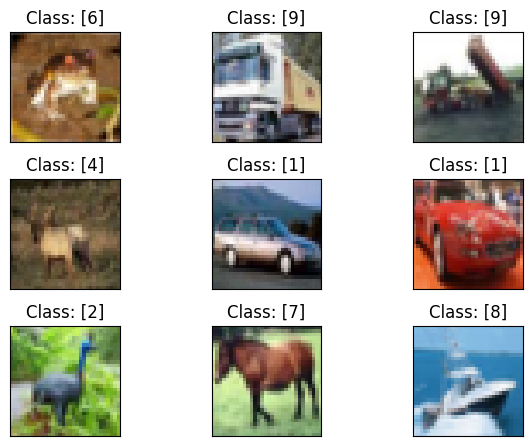

In [3]:
fig = plt.figure()

for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.tight_layout()
  plt.imshow(X_train_full[i], interpolation='none')
  plt.title('Class: {}'.format(y_train_full[i]))
  plt.xticks([])
  plt.yticks([])

In [4]:
X_train_full.shape

(50000, 32, 32, 3)

In [5]:
y_train_full.shape

(50000, 1)

In [6]:
# Train, Validate & Test
# Split train_full into train & test
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers,models
import random
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop

K.clear_session()

# Normalize the pixel values to [0, 1]
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# Calculate the mean and std for each RGB channel for train and test
# Then normalize by subtracting mean and dividing by std
train_mean = np.mean(X_train_full, axis=(0, 1, 2))  # Channel-wise mean for (Train)
train_std = np.std(X_train_full, axis=(0, 1, 2))    # Channel-wise std for (Train)
x_train_full_norm = (X_train_full - train_mean) / train_std

test_mean = np.mean(X_train_full, axis=(0, 1, 2))  # Channel-wise mean for (Test)
test_std = np.std(X_train_full, axis=(0, 1, 2))    # Channel-wise std for (Test)
x_test_norm = (X_test - test_mean) / test_std

'''
# Z-score normalization
x_train_full_norm = np.zeros_like(X_train_full)
x_test_norm = np.zeros_like(X_test)
# Normalize each channel of the RGB channels
for i in range(3):
    mean = X_train_full[:, :, :, i].mean()
    std_dev = X_train_full[:, :, :, i].std()
    #print(mean,std_dev)
    x_train_full_norm[:, :, :, i] = (X_train_full[:, :, :, i] - mean) / std_dev
    #x_val_norm[:, :, :, i] = (x_val_norm[:, :, :, i] - mean) / std_dev
    x_test_norm[:, :, :, i] = (X_test[:, :, :, i] - mean) / std_dev

#print(x_train_norm)
#print(x_test_norm)
'''

X_train, X_val, y_train, y_val = train_test_split(x_train_full_norm, y_train_full, test_size=0.2, random_state=47)

print("===============================================")
print("X_train.shape", X_train.shape)  # (40000, 32, 32, 3)
print("y_train.shape",y_train.shape)  # (40000, 1)
print("===============================================")
print("X_val.shape",X_val.shape)    # (10000, 32, 32, 3)
print("y_val.shape",y_val.shape)    # (10000, 1)
print("===============================================")
print("X_test.shape", X_test.shape)             # (10000, 32, 32, 3)
print("y_test.shape", y_test.shape)             # (10000, 1)


X_train.shape (40000, 32, 32, 3)
y_train.shape (40000, 1)
X_val.shape (10000, 32, 32, 3)
y_val.shape (10000, 1)
X_test.shape (10000, 32, 32, 3)
y_test.shape (10000, 1)


In [7]:
print(y_train[0], y_train[10], y_train[200])

[0] [1] [4]


In [8]:
# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(40000, 10)
(10000, 10)
(10000, 10)


In [9]:
print(y_train[0], y_train[10], y_train[200])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


### AlexNet - Using Functional API

*   **1st Fully Connected Layer (HeUniform) & 2nd Fully Connected Layer (glorot_uniform)**
 * Epoch 75/75: accuracy: 0.4932 - loss: 1.4275 - val_accuracy: 0.4874 - val_loss: 1.4742

*   **1st Fully Connected Layer (HeUniform) & 2nd Fully Connected Layer (HeUniform)**
 * Epoch 75/75: accuracy: 0.4861 - loss: 1.4414 - val_accuracy: 0.4787 - val_loss: 1.4901
*   **1st Fully Connected Layer (glorot_uniform) & 2nd Fully Connected Layer (HeUniform)**
 * Epoch 75/75: accuracy: 0.5031 - loss: 1.3874 - val_accuracy: 0.4853 - val_loss: 1.4849
*   **1st Fully Connected Layer (glorot_uniform) & 2nd Fully Connected Layer (glorot_uniform)**
 * Epoch 63/75: accuracy: 0.4907 - loss: 1.4351 - val_accuracy: 0.4714 - val_loss: 1.4999


In [10]:
def AlexNetScaled(input_shape=(32, 32, 3), num_classes=10):
  # Input layer
  inputs = layers.Input(shape=input_shape)

  # 1st Convolutional Layer
  x = layers.Conv2D(filters=64, kernel_size=(3, 3),
                    strides=(4, 4), padding='same', activation='relu', kernel_initializer='HeUniform')(inputs)
  x = layers.BatchNormalization()(x)  # BatchNorm after Conv layer
  # 1st Pooling Layer
  x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
  x = layers.Dropout(0.4)(x)  # Dropout after 1st pooling layer

  # 2nd Convolutional Layer
  x = layers.Conv2D(filters=128, kernel_size=(3, 3),
                    strides=(1, 1), padding='same', activation='relu', kernel_initializer='HeUniform')(x)
  x = layers.BatchNormalization()(x)  # BatchNorm after Conv layer
  # 2nd Pooling Layer
  x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
  x = layers.Dropout(0.5)(x)  # Dropout after 2nd pooling layer

  # 3rd Convolutional Layer
  x = layers.Conv2D(filters=256, kernel_size=(3, 3),
                      strides=(1, 1), padding='same', activation='relu', kernel_initializer='HeUniform')(x)
  x = layers.BatchNormalization()(x)  # BatchNorm after Conv layer

  # 4th Convolutional Layer
  x = layers.Conv2D(filters=256, kernel_size=(3, 3),
                      strides=(1, 1), padding='same', activation='relu', kernel_initializer='HeUniform')(x)
  x = layers.BatchNormalization()(x)  # BatchNorm after Conv layer

  # 5th Convolutional Layer
  x = layers.Conv2D(filters=1024, kernel_size=(3, 3),
                    strides=(1, 1), padding='same', activation='relu', kernel_initializer='HeUniform')(x)
  x = layers.BatchNormalization()(x)  # BatchNorm after Conv layer

  # 3rd Pooling Layer
  x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
  x = layers.Dropout(0.5)(x)  # Dropout after 3rd pooling layer

  # Flatten the network output for Fully Connected Layers
  x = layers.Flatten()(x)

  # 1st Fully Connected Layer
  x = layers.Dense(1024, activation='relu', kernel_initializer='HeUniform')(x) #glorot_uniform
  x = layers.Dropout(0.5)(x)  # Dropout for regularization

  # 2nd Fully Connected Layer
  x = layers.Dense(2048, activation='relu', kernel_initializer='glorot_uniform')(x) # HeUniform
  x = layers.Dropout(0.5)(x)  # Dropout for regularization

  # Output Layer (with softmax for classification)
  outputs = layers.Dense(num_classes, activation='softmax')(x)

  # Create the model
  model = models.Model(inputs=inputs, outputs=outputs)

  return model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 8, 8, 64)            │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 2, 2, 1024)          │       2,360,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2, 2, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 1, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,049,6

 Total params: 6,497,418 (24.79 MB)

 Trainable params: 6,493,962 (24.77 MB)

 Non-trainable params: 3,456 (13.50 KB)

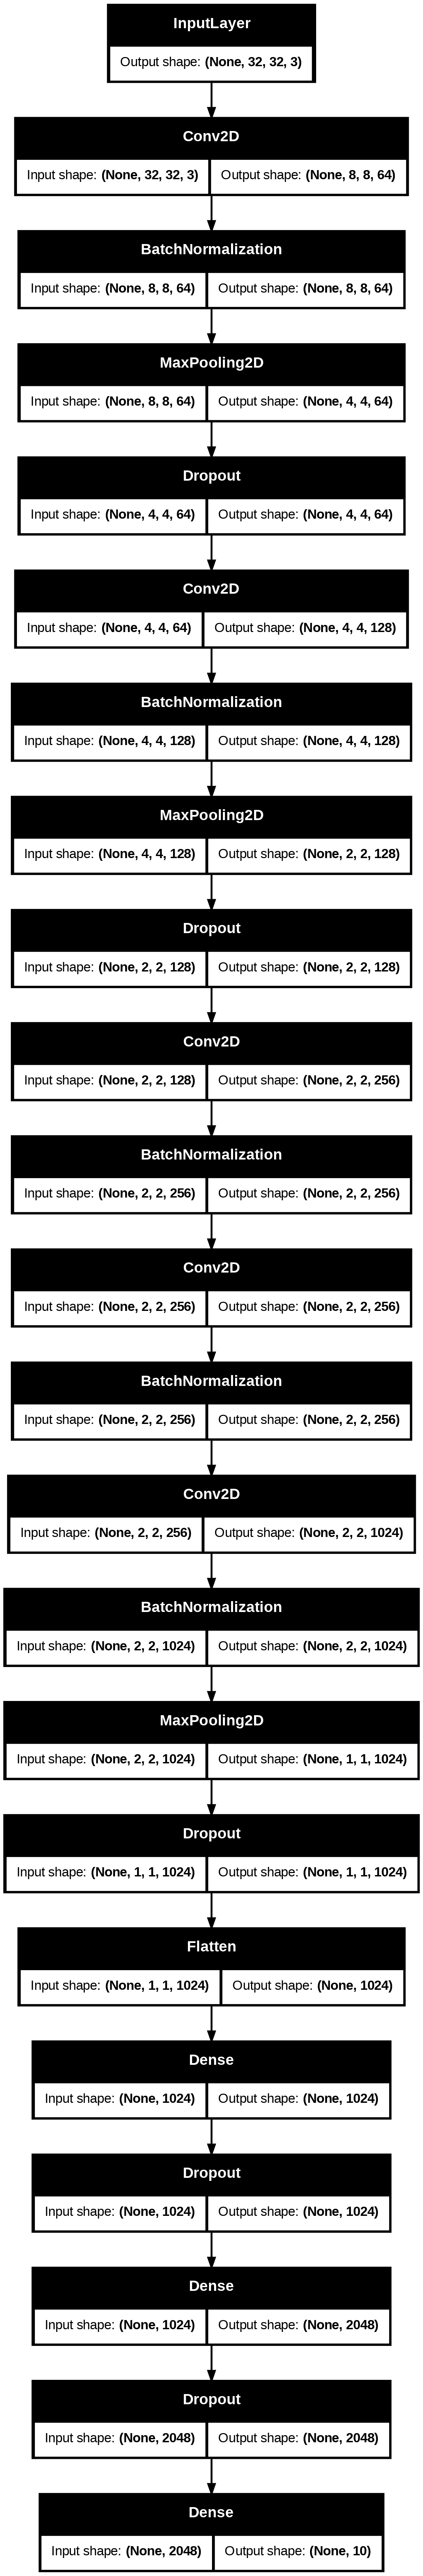

In [11]:
# Define model parameters
input_shape=X_train[0].shape # CIFAR-10 image size = (32, 32, 3)
num_classes = 10           # Number of classes for CIFAR-10

# Build the model using the Functional API
alexnet_scaled_model = AlexNetScaled(input_shape=input_shape, num_classes=num_classes)

# Summary of the model
alexnet_scaled_model.summary()
keras.utils.plot_model(alexnet_scaled_model, show_shapes=True)

In [12]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import datetime
# Compile the model

optimizer = Adam(learning_rate=0.0001)  # SGD # Set the desired learning rate here

alexnet_scaled_model.compile(optimizer=optimizer, #'adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

# Create the TensorBoard callback
#tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# Early stopping with patience of 5 epochs, monitoring validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
alexnet_scaled_model.fit(X_train, y_train, epochs=75, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/75
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.1417 - loss: 3.3383 - val_accuracy: 0.2117 - val_loss: 2.0766
Epoch 2/75
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2163 - loss: 2.1166 - val_accuracy: 0.2616 - val_loss: 1.9720
Epoch 3/75
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2552 - loss: 1.9830 - val_accuracy: 0.3164 - val_loss: 1.8993
Epoch 4/75
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2940 - loss: 1.8915 - val_accuracy: 0.3584 - val_loss: 1.7610
Epoch 5/75
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3249 - loss: 1.8148 - val_accuracy: 0.3891 - val_loss: 1.7093
Epoch 6/75
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3471 - loss: 1.7653 - val_accuracy: 0.3761 - val_loss: 1.7146
Epoch 7/75
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3642 - loss: 1.7210 - val_accuracy: 0.4224 - val_loss: 1.6147
Epoch 8/75
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3847 - loss: 1.6831 -

In [13]:
'''
K.clear_session()

inputs = keras.Input(shape=(32, 32, 3), name='inputCIFAR10')

# 1st convolutional layer
x=layers.Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(3,3), strides=(1,1), padding='valid', name='Conv1')(inputs)
x=layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='maxpool1')(x)
x=layers.Dropout(0.5)(x)

# Dense Layer
flat = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu', kernel_initializer='glorot_uniform')(flat)
x = layers.Dropout(0.4)(x)

x=layers.Dense(4096, activation='relu', kernel_initializer='glorot_uniform')(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='CIFAR10_AlexNet_by_Sam')
model.summary()
keras.utils.plot_model(model, show_shapes=True)
'''

"\nK.clear_session()\n\ninputs = keras.Input(shape=(32, 32, 3), name='inputCIFAR10')\n\n# 1st convolutional layer\nx=layers.Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(3,3), strides=(1,1), padding='valid', name='Conv1')(inputs)\nx=layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='maxpool1')(x)\nx=layers.Dropout(0.5)(x)\n\n# Dense Layer\nflat = layers.Flatten()(x)\nx = layers.Dense(4096, activation='relu', kernel_initializer='glorot_uniform')(flat)\nx = layers.Dropout(0.4)(x)\n\nx=layers.Dense(4096, activation='relu', kernel_initializer='glorot_uniform')(x)\nx = layers.Dropout(0.4)(x)\n\noutputs = layers.Dense(10, activation='softmax')(x)\n\nmodel = keras.Model(inputs=inputs, outputs=outputs, name='CIFAR10_AlexNet_by_Sam')\nmodel.summary()\nkeras.utils.plot_model(model, show_shapes=True)\n"